<a href="https://colab.research.google.com/github/aderdouri/ActuarialThesis/blob/master/Notebooks/Regressors/myXGBoostRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Régression XGBoost

## Cloner la branche contenant le dataset le code qui va avec.

In [ ]:
!rm -rf ActuarialThesis
!git clone https://github.com/aderdouri/ActuarialThesis.git
%ls -ltr ActuarialThesis

Cloning into 'ActuarialThesis'...
remote: Enumerating objects: 872, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 872 (delta 73), reused 113 (delta 41), pack-reused 717
Receiving objects: 100% (872/872), 123.29 MiB | 13.37 MiB/s, done.
Resolving deltas: 100% (363/363), done.
total 96
drwxr-xr-x 2 root root  4096 Oct 26 12:42 AllstateClaimPredictionChallenge/
drwxr-xr-x 2 root root  4096 Oct 26 12:42 AllstateClaimsSeverity/
drwxr-xr-x 2 root root  4096 Oct 26 12:42 Data/
drwxr-xr-x 2 root root  4096 Oct 26 12:42 EMTboost/
drwxr-xr-x 2 root root  4096 Oct 26 12:42 FrenchMotorThirdPartyLiabilityClaims/
drwxr-xr-x 2 root root  4096 Oct 26 12:42 Models/
drwxr-xr-x 2 root root  4096 Oct 26 12:42 Plots/
drwxr-xr-x 2 root root  4096 Oct 26 12:42 Notebooks/
drwxr-xr-x 2 root root  4096 Oct 26 12:42 src/
-rw-r--r-- 1 root root    54 Oct 26 12:42 README.md
-rw-r--r-- 1 root root 19545 Oct 26 12:42 myXGBoostRegressor.ipynb
-r

In [ ]:
!mkdir ActuarialThesis/plots_rgr
!ls -ltr ActuarialThesis/plots_rgr

total 0


In [ ]:
# Ajouter le répértoire src
import sys
sys.path.insert(0,'./ActuarialThesis/src/')

In [ ]:
import installHelper

In [ ]:
# Installer les packages nécéssaires
%time installHelper.installALL()

CPU times: user 365 ms, sys: 88.3 ms, total: 454 ms
Wall time: 1min 55s


In [ ]:
# On doit trouver tous les packages mentionés dans le grep
!pip list -v | grep -e catboost -e 'imbalanced-learn' -e 'optuna' -e 'catboost' -e 'lime' -e 'shap'

catboost                         1.2.2                 /usr/local/lib/python3.10/dist-packages pip
imbalanced-learn                 0.10.1                /usr/local/lib/python3.10/dist-packages pip
lime                             0.2.0.1               /usr/local/lib/python3.10/dist-packages pip
optuna                           3.4.0                 /usr/local/lib/python3.10/dist-packages pip
shap                             0.43.0                /usr/local/lib/python3.10/dist-packages pip
shapely                          2.0.2                 /usr/local/lib/python3.10/dist-packages pip


In [ ]:
# Importer les packages nécéssaires
from helper import *

In [ ]:
# Appliquer le theme par défaut
#sns.set_theme()

## Partir du dataset déjà encodé.

In [ ]:
df = pd.read_csv('ActuarialThesis/Data/encodedBASEAUTO.csv')
df.head()

,ACV,SEX,STATUT,AGECOND,K8000,RM,CAR,USAGE_Prive,USAGE_PriveTrajet,USAGE_Professionnel,...,SEGM_H,SEGM_M1,SEGM_M2,GARAGE_ClosCollectif,GARAGE_GarageAutre,GARAGE_IndividuelClos,CSP_CSP_50,CSP_CSP_60,CSP_CSP_AUTRE,CHARGE
0,1.134929,1,1,-0.457663,0,-0.094064,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1.134929,1,0,1.101165,0,-0.817279,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.134929,1,1,-1.813166,0,1.507343,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.134929,1,0,0.626739,0,-0.817279,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.134929,1,0,-1.203190,0,1.507343,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
X = df.drop('CHARGE', axis=1)
y = df['CHARGE']

Tout d'abord, nous séparons la cible du cadre de données avec des caractéristiques (df -> X, y).

Ensuite, nous divisons les données en ensembles train/val/test dans le rapport 60:20:20. L'idée est que nous utiliserons l'ensemble train pour entraîner nos modèles, l'ensemble val pour les valider et l'ensemble test pour calculer l'erreur finale du mélange. L'ensemble de test sera donc constitué de données totalement inédites.

Pour ce faire, utilisez un train_test_split régulier de sklearn pour diviser X et y en parties train et val/test dans le ratio 60:40. Ensuite, utilisez à nouveau train_test_split, mais pour diviser la partie val/test obtenue en validation et test dans un rapport 50:50. Dans chaque application de train_test_split, utilisez random_state=13 et les autres valeurs de paramètres par défaut.

Au final, vous devriez obtenir X_train, X_val, X_test avec les formes suivantes, respectivement : (23786, 58), (7929, 58), (7929, 58). La même logique s'applique à y_train, y_val, y_test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=13)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=13)

### Option 2 of the split:

In [ ]:
# Partir du dataset déja encodé et splité en Train/Test
df_train = pd.read_csv('ActuarialThesis/Data/encodedTrainBASEAUTO.csv')
df_test = pd.read_csv('ActuarialThesis/Data/encodedTestBASEAUTO.csv')

X_train = df_train.drop('CHARGE', axis=1)
y_train = df_train['CHARGE']

X_test = df_test.drop('CHARGE', axis=1)
y_test = df_test['CHARGE']

# Split the train set into Train/Val sets: 80:20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=13)

In [ ]:
xgb_rgr = XGBRegressor(objective='reg:squarederror',
                       n_estimators=500,
                       learning_rate=0.01,
                       max_depth=5,
                       early_stopping_rounds=50,
                       random_state=13)

xgb_rgr.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False)

y_pred_xgb_rgr = xgb_rgr.predict(X_test)
rmse = mean_squared_error(y_test, y_pred_xgb_rgr, squared=False)
print("RMSE: %.5f" % rmse)

RMSE: 1334.59729


In [ ]:
xgb_rgr = XGBRegressor(objective='reg:tweedie',
                       tweedie_variance_power=1.3,
                       n_estimators=500,
                       learning_rate=0.01,
                       max_depth=5,
                       early_stopping_rounds=50,
                       random_state=13
                       )

xgb_rgr.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False)

y_pred_xgb_rgr = xgb_rgr.predict(X_test)
rmse = mean_squared_error(y_test, y_pred_xgb_rgr, squared=False)
print("RMSE: %.5f" % rmse)

RMSE: 1327.30104


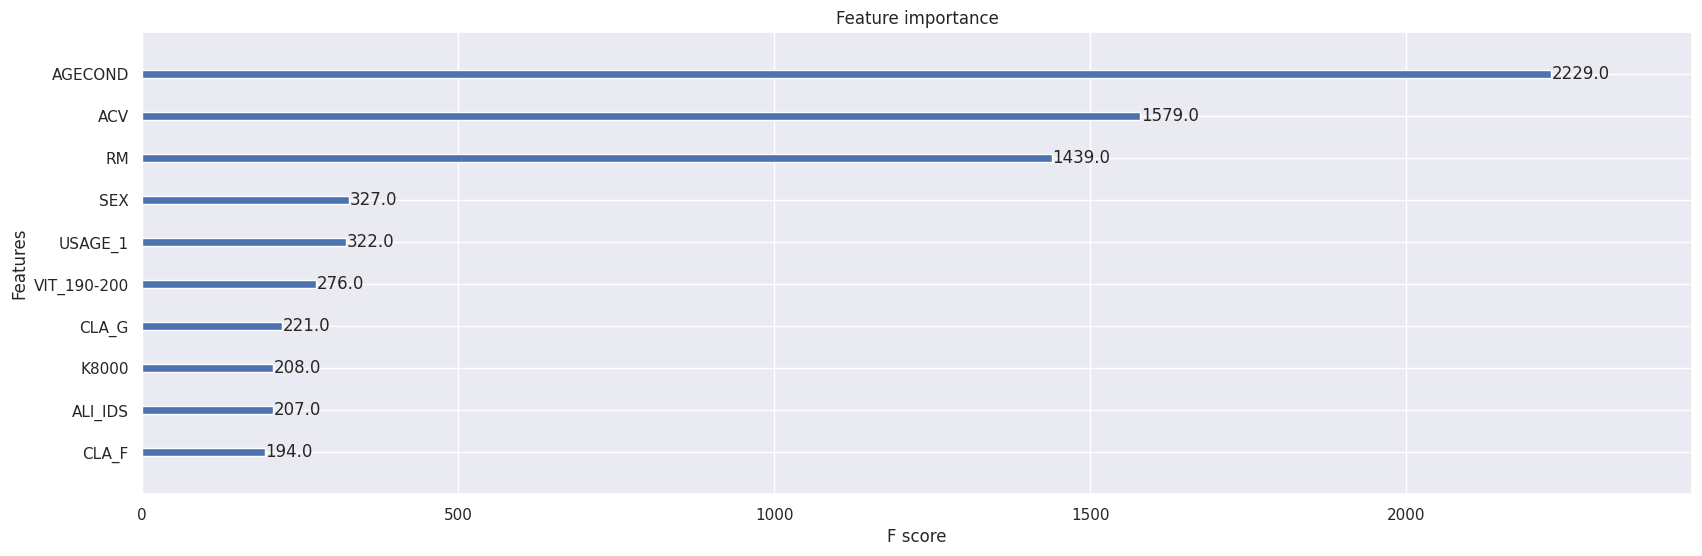

In [ ]:
from xgboost import plot_importance
ax = plot_importance(xgb_rgr, max_num_features=10)
ax.figure.set_size_inches(20, 6)
ax.figure.savefig('./ActuarialThesis/plots_rgr/myXGBoostRegressorFeatureImportances.pdf')

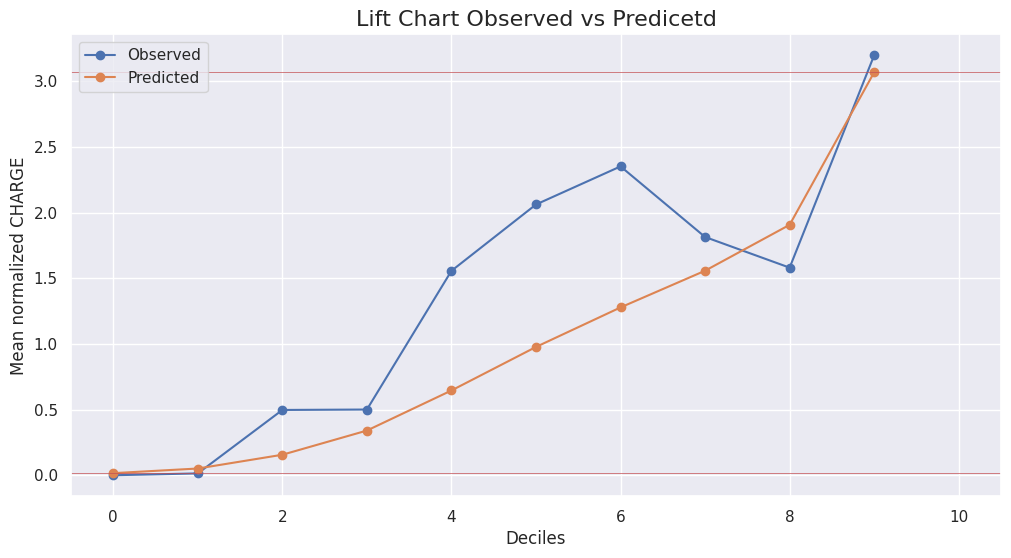

In [ ]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_xgb_rgr)
fig, ax = plotLiftChart(df_ObsVsPred);
fig.savefig('./ActuarialThesis/plots_rgr/myXGBoostRegressorLiftChart.pdf')

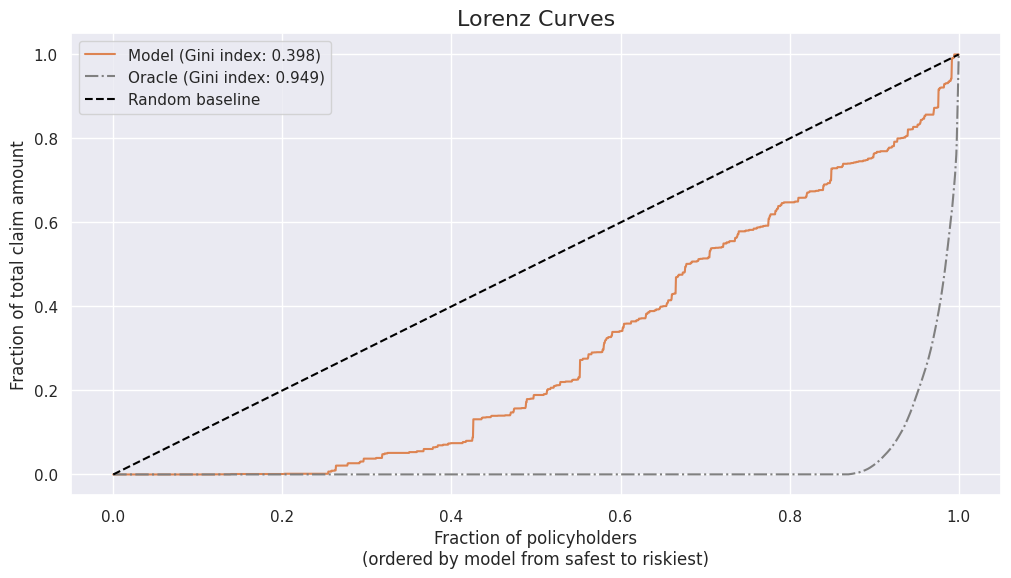

In [ ]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_xgb_rgr)
fig, ax = plotLorenzCurve(df_ObsVsPred)
#fig.set_size_inches(12, 6)
fig.savefig('./ActuarialThesis/plots_rgr/myXGBoostRegressorLorenzCurve.pdf')

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
SAMPLE_RATE = 0.4
RANDOM_SEED = 1
EARLY_STOPPING_ROUND = 100
EPOCHS=10000
NUM_TRIALS = 500

In [ ]:
#from sklearn.model_selection import RepeatedKFold
#from optuna.integration import XGBoostPruningCallback

RS = 13  # random state
N_JOBS = 8  # number of parallel threads

# repeated K-folds
N_SPLITS = 10
N_REPEATS = 1

# Optuna
N_TRIALS = 100
MULTIVARIATE = True

# XGBoost
EARLY_STOPPING_ROUNDS = 100

In [ ]:
def objective(
    trial, X, y,
    random_state=13,
    n_splits=3,
    n_repeats=2,
    n_jobs=1,
    early_stopping_rounds=50,
):
    # XGBoost parameters
    params = {
        'verbosity': 0,
        #"objective": "reg:squarederror",
        'objective': trial.suggest_categorical('objective', ['reg:tweedie']),
        'n_estimators': 10000,
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 0.6),
        'subsample': trial.suggest_float('subsample', 0.4, 0.8),
        'alpha': trial.suggest_float('alpha', 0.01, 10.0),
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0),
        'gamma': trial.suggest_float('lambda', 1e-8, 10.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 10, 1000),
        'seed': random_state,
        'n_jobs': n_jobs,
    }

    #param = {
    #    'objective': trial.suggest_categorical('objective', ['reg:squarederror', 'reg:tweedie']),
    #    'max_depth': trial.suggest_int('max_depth', 1, 10),
    #    'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0),
    #    'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
    #    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    #    'gamma': trial.suggest_float('gamma', 0.01, 1.0),
    #    'subsample': trial.suggest_float('subsample', 0.001, 1.0),
    #    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
    #    'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
    #    'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
    ##    #'random_state': trial.suggest_int('random_state', 1, 1000)
    #}

    if params['objective'] == 'reg:tweedie':
        params['tweedie_variance_power'] = trial.suggest_float('tweedie_variance_power', 1, 2)


    model = XGBRegressor(**params)
    pruning_callback = XGBoostPruningCallback(trial, "validation_0-rmse")
    rkf = RepeatedKFold(
        n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
    )
    X_values = X.values
    y_values = y.values
    y_pred = np.zeros_like(y_values)
    for train_index, test_index in rkf.split(X_values):
        X_A, X_B = X_values[train_index, :], X_values[test_index, :]
        y_A, y_B = y_values[train_index], y_values[test_index]
        model.fit(
            X_A,
            y_A,
            eval_set=[(X_B, y_B)],
            eval_metric="rmse",
            verbose=False,
            callbacks=[pruning_callback],
            early_stopping_rounds=early_stopping_rounds,
        )
        y_pred[test_index] += model.predict(X_B)
    y_pred /= n_repeats
    return np.sqrt(mean_squared_error(y_train, y_pred))

In [ ]:
# Create the study
#study = optuna.create_study(direction='minimize', study_name='xgb_regression')
#study.optimize(objective, n_trials=NUM_TRIALS)

In [ ]:
# Create the study
#sampler = TPESampler(seed=RS, multivariate=MULTIVARIATE)
study = optuna.create_study(direction="minimize")#, sampler=sampler)
study.optimize(
    lambda trial: objective(
        trial,
        X_train,
        y_train,
        random_state=13,
        n_splits=N_SPLITS,
        n_repeats=N_REPEATS,
        n_jobs=8,
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
    ),
    n_trials= N_TRIALS,
    n_jobs=1,
)

In [ ]:
xgx_reg_hp = study.best_params
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 1394.231921828505
  Params: 
    objective: reg:tweedie
    max_depth: 4
    learning_rate: 0.042029862461369125
    colsample_bytree: 0.5711895944308994
    subsample: 0.5411213855618349
    alpha: 5.835067732086724
    lambda: 6.276955677369005
    min_child_weight: 695.0944784712658
    tweedie_variance_power: 1.2149336293286312


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.write_image("./ActuarialThesis/plots_rgr/myXGBoostRegressorParamImportances.pdf")
fig.show()

In [ ]:
optimized_xgb_rgr = XGBRegressor(**xgx_reg_hp)
optimized_xgb_rgr.fit(X_train, y_train)
y_pred_xgb_rgr = optimized_xgb_rgr.predict(X_test)
print('RMSE: ', mean_squared_error(y_test, y_pred_xgb_rgr, squared=False))

RMSE:  1324.1738212839145


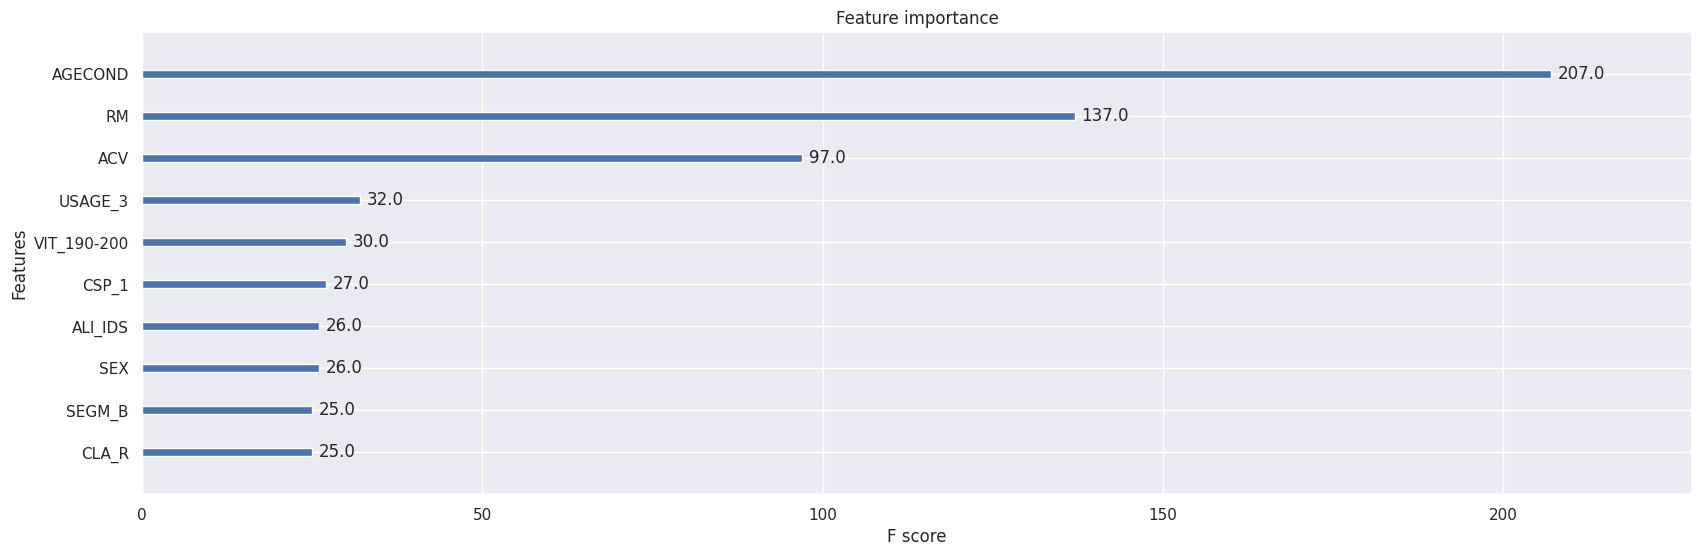

In [ ]:
from xgboost import plot_importance
ax = plot_importance(optimized_xgb_rgr, max_num_features=10)
ax.figure.set_size_inches(20, 6)
ax.figure.savefig('./ActuarialThesis/plots_rgr/myXGBoostRegressorFeatureImportances.pdf')

RMSE:  1324.1738212839145


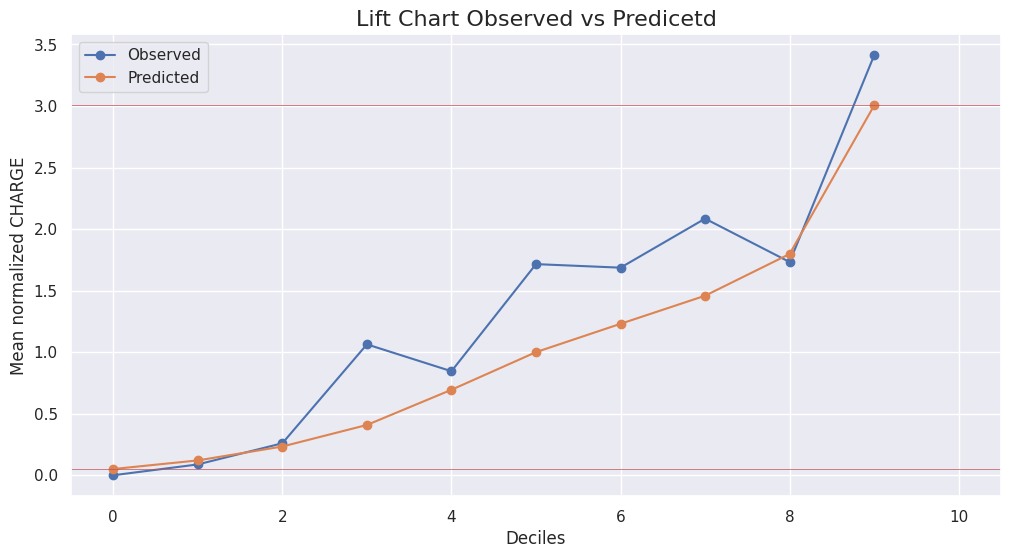

In [ ]:
y_pred_xgb_rgr = optimized_xgb_rgr.predict(X_test)
print('RMSE: ', mean_squared_error(y_test, y_pred_xgb_rgr, squared=False))
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_xgb_rgr)
fig, ax = plotLiftChart(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myXGBoostRegressorLiftChart.pdf')

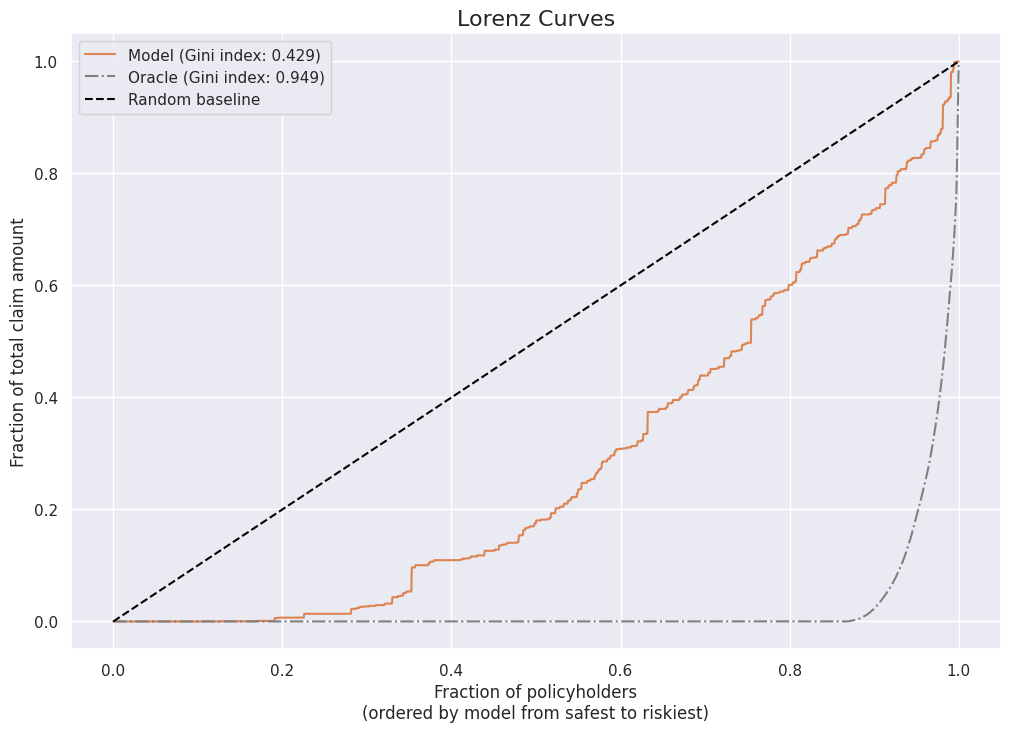

In [ ]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_xgb_rgr)
fig, ax = plotLorenzCurve(df_ObsVsPred)
fig.set_size_inches(12, 8)
fig.savefig('./ActuarialThesis/plots_rgr/myXGBoostRegressorLorenzCurve.pdf')

In [ ]:
np.mean(y_test), np.mean(y_pred_xgb_rgr)

(248.89134570311523, 193.1167)

In [ ]:
np.std(y_test), np.std(y_pred_xgb_rgr)

(1336.5080972003657, 180.7171)